# MadMiner physics tutorial (part 3B)

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3A of this tutorial we will finally train a neural network to estimate likelihood ratios. We assume that you have run part 1 and 2A of this tutorial. If, instead of 2A, you have run part 2B, you just have to load a different filename later.

## Preparations

Make sure you've run the first tutorial before executing this notebook!

In [1]:
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ScoreEstimator

In [2]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [61]:
sampler = SampleAugmenter("data/lhe_data_Jonas_shuffled.h5")
# sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

16:50 madminer.analysis.da INFO    Loading data from data/lhe_data_Jonas_shuffled.h5
16:50 madminer.utils.inter ERROR   HDF5 file does not contain nuisance parameters information
16:50 madminer.utils.inter ERROR   HDF5 file does not contain finite difference information
16:50 madminer.utils.inter ERROR   HDF5 file does not contain systematic information
16:50 madminer.analysis.da INFO    Found 2 parameters
16:50 madminer.analysis.da INFO      0: ctG (LHA: DIM6 16, Power: 2, Range: (-2.0, 2.0)Label: None)
16:50 madminer.analysis.da INFO      1: ctq8 (LHA: DIM6 55, Power: 2, Range: (-5.0, 5.0)Label: None)
16:50 madminer.analysis.da INFO    Did not find nuisance parameters
16:50 madminer.analysis.da INFO    Found 6 benchmarks
16:50 madminer.analysis.da INFO    Found 12 observables
16:50 madminer.analysis.da INFO    Found 90000 events
16:50 madminer.analysis.da INFO      50000 signal events sampled from benchmark sm
16:50 madminer.analysis.da INFO      10000 signal events sampled from benc

In [66]:
SampleAugmenter.sample_train_local?

The relevant `SampleAugmenter` function for local score estimators is `extract_samples_train_local()`. As in part 3a of the tutorial, for the argument `theta` you can use the helper functions `sampling.benchmark()`, `sampling.benchmarks()`, `sampling.morphing_point()`, `sampling.morphing_points()`, and `sampling.random_morphing_points()`.

In [62]:
x, theta, t_xz, _ = sampler.sample_train_local(
    theta=sampling.benchmark("sm"),
    n_samples=500000,
    folder="./data/samples",
    filename="train_score",
)

16:50 madminer.sampling.sa INFO    Extracting training sample for local score regression. Sampling and score evaluation according to sm
16:50 madminer.sampling.sa INFO    Starting sampling serially
16:50 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:50 madminer.sampling.sa INFO    Effective number of samples: mean 29971.0, with individual thetas ranging from 29971.0 to 29971.0


We can use the same data as in part 3a, so you only have to execute this if you haven't gone through tutorial 3a:

In [63]:
_ = sampler.sample_test(
    theta=sampling.benchmark("sm"),
    n_samples=1000,
    folder="./data/samples",
    filename="test",
)

16:50 madminer.sampling.sa INFO    Extracting evaluation sample. Sampling according to sm
16:50 madminer.sampling.sa INFO    Starting sampling serially
16:50 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:50 madminer.sampling.sa INFO    Effective number of samples: mean 10009.0, with individual thetas ranging from 10009.0 to 10009.0


## 2. Train score estimator

It's now time to build a neural network. Only this time, instead of the likelihood ratio itself, we will estimate the gradient of the log likelihood with respect to the theory parameters -- the score. To be precise, the output of the neural network is an estimate of the score at some reference parameter point, for instance the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

The central object for this is the `madminer.ml.ScoreEstimator` class:

In [64]:
estimator = ScoreEstimator(n_hidden=(30,30))

In [68]:
a = (20,20)

In [85]:
str(len(a))

'2'

In [76]:
estimator.train(
    method="sally",
    x="data/samples/x_train_score.npy",
    t_xz="data/samples/t_xz_train_score.npy",
)

estimator.save("models/sally")

17:19 madminer.ml.score    INFO    Starting training
17:19 madminer.ml.score    INFO      Batch size:             128
17:19 madminer.ml.score    INFO      Optimizer:              amsgrad
17:19 madminer.ml.score    INFO      Epochs:                 50
17:19 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
17:19 madminer.ml.score    INFO      Validation split:       0.25
17:19 madminer.ml.score    INFO      Early stopping:         True
17:19 madminer.ml.score    INFO      Scale inputs:           True
17:19 madminer.ml.score    INFO      Shuffle labels          False
17:19 madminer.ml.score    INFO      Samples:                all
17:19 madminer.ml.score    INFO    Loading training data
17:19 madminer.utils.vario INFO      Loading data/samples/x_train_score.npy into RAM
17:19 madminer.utils.vario INFO      Loading data/samples/t_xz_train_score.npy into RAM
17:19 madminer.ml.score    INFO    Found 500000 samples with 2 parameters and 12 observables

KeyboardInterrupt: 

## 3. Evaluate score estimator

Let's evaluate the SM score on the test data

In [31]:
estimator.load("models/sally")

t_hat = estimator.evaluate_score(x="data/samples/x_test.npy")

12:59 madminer.ml.base     INFO    Loading model from models/sally
12:59 madminer.utils.vario INFO      Loading data/samples/x_test.npy into RAM


In [32]:
t_hat[:, 0]

array([-1.03674456e-01,  1.14438310e-01, -5.85472286e-01, -8.18762630e-02,
       -1.17692411e+00, -2.68298745e-01, -4.83081698e-01, -4.17623460e-01,
        1.67544082e-01,  3.65674853e-01,  9.32191759e-02,  9.28804278e-01,
       -1.04876256e+00, -3.07875574e-01,  1.49951863e+00, -2.87132740e-01,
       -4.79348004e-01, -2.12416753e-01, -8.31633449e-01,  3.40487123e-01,
        4.68349993e-01, -1.24494171e+00, -3.40370834e-03, -5.80854058e-01,
        7.05682933e-01,  1.90638438e-01,  4.65191752e-02, -5.80092549e-01,
       -6.65707529e-01, -1.20726025e+00, -6.51923269e-02, -2.36880034e-02,
       -8.14382285e-02,  5.69425344e-01,  1.89081386e-01,  3.67739081e-01,
       -3.33930433e-01, -4.58245099e-01,  3.89033973e-01,  1.04380774e+00,
       -8.39351773e-01, -3.00150692e-01, -8.23931694e-01,  5.77313662e-01,
        7.72829652e-01,  1.21826208e+00, -8.71931076e-01, -2.25636408e-01,
        9.21462923e-02, -2.76495457e-01, -1.10208058e+00, -1.81096718e-01,
        8.94214660e-02,  

In [33]:
x = np.load("data/samples/x_test.npy")
print(x[:, 1])

[-1.16892195e+00  2.04126239e+00 -1.45278108e+00  1.44152057e+00
 -1.56294942e+00  1.35303795e+00  7.44892180e-01 -1.45360374e+00
  7.37043023e-01  7.47261524e-01  7.51223505e-01 -9.34475064e-02
  2.10655093e+00  5.57956994e-01  1.32553184e+00  4.69133109e-02
  1.83098865e+00 -1.80780947e+00 -1.69357204e+00 -9.29450333e-01
 -6.84019364e-03 -1.12195879e-01 -1.92087173e+00 -1.19902456e+00
  3.77935708e-01  4.87689003e-02  7.48099864e-01 -1.29801178e+00
  5.40750384e-01  6.45077496e-04 -1.12498462e+00  3.52706254e-01
 -3.03078294e+00 -1.15772688e+00 -5.52465320e-01 -1.74453467e-01
  4.83685911e-01 -4.30805534e-01  3.87669027e-01  2.05074087e-01
  1.00612891e+00  1.93888283e+00  1.49851871e+00  2.31834337e-01
  1.17502585e-01 -1.01451385e+00 -6.78178489e-01  4.77012813e-01
 -1.09640479e+00  1.86586595e+00  1.63425934e+00 -1.58022106e-01
 -4.84728098e-01  1.47098172e+00  1.64190221e+00 -1.19737613e+00
  1.44152057e+00  1.09726322e+00 -1.90402061e-01 -1.65559244e+00
  1.30718338e+00  4.29003

Let's have a look at the estimated score and how it is related to the observables:

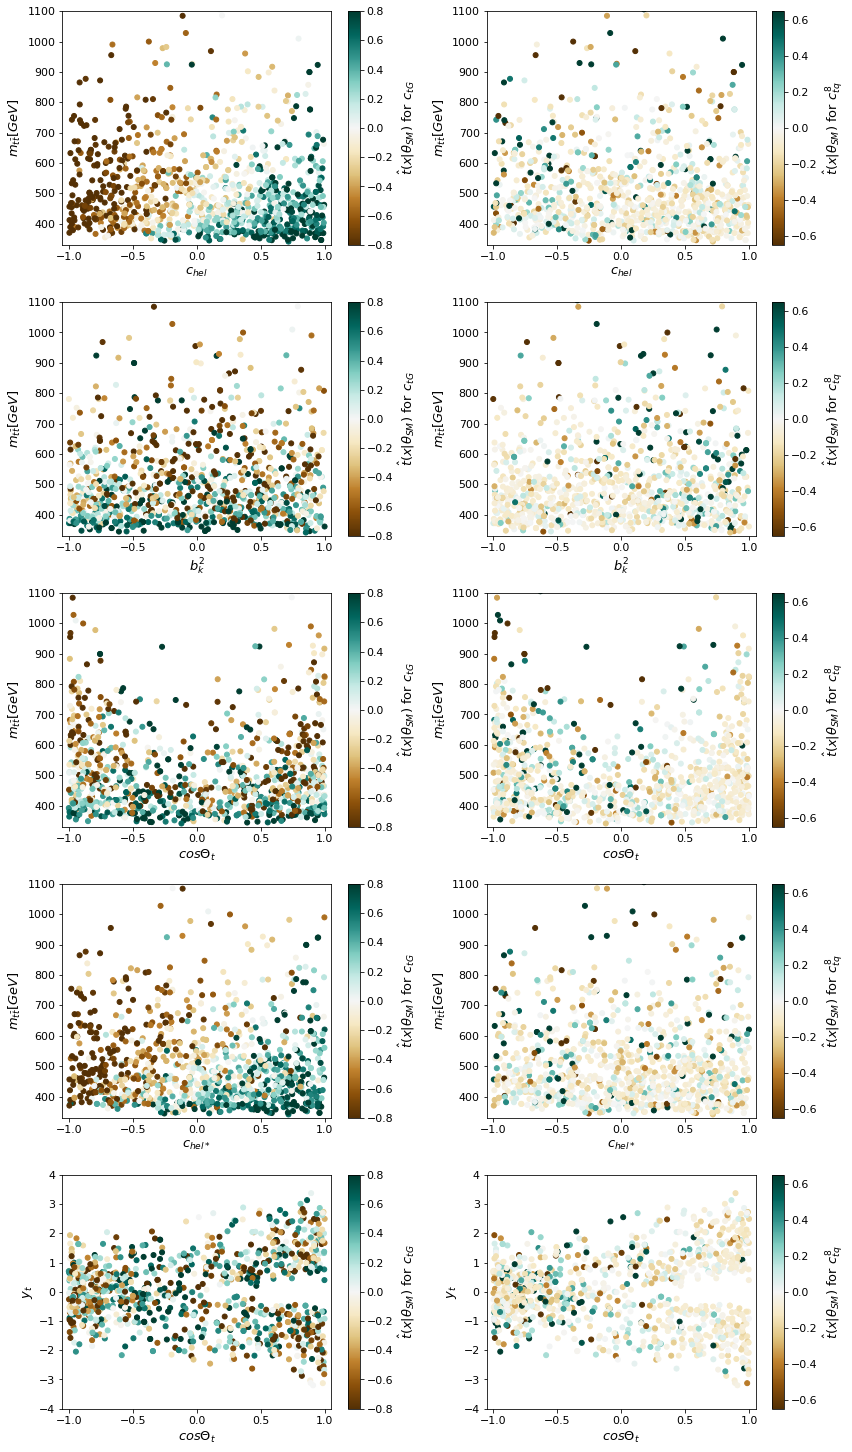

In [60]:
x = np.load("data/samples/x_test.npy")

Nplots=10
fig = plt.figure(figsize=(12, 4*Nplots))

plt.rcParams.update({'font.size': 11, 'axes.labelsize': 13}) #change 14 to whatever font size you want

#mtt vs chel
ax = plt.subplot(Nplots, 2, 1)
sc = plt.scatter(
    x[:, 10],
    x[:, 0],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$c_{hel}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

ax = plt.subplot(Nplots, 2, 2)
sc = plt.scatter(
    x[:, 10],
    x[:, 0],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.65,
    vmax=+0.65,
)
cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$c_{hel}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

#b2k vs chel
ax = plt.subplot(Nplots, 2, 3)
sc = plt.scatter(
    x[:, 5],
    x[:, 0],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$b^2_{k}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

ax = plt.subplot(Nplots, 2, 4)
sc = plt.scatter(
    x[:, 5],
    x[:, 0],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.65,
    vmax=+0.65,
)
cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$b^2_{k}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

#thetaT vs chel
ax = plt.subplot(Nplots, 2, 5)
sc = plt.scatter(
    x[:, 3],
    x[:, 0],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$cos \Theta_t$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

ax = plt.subplot(Nplots, 2, 6)
sc = plt.scatter(
    x[:, 3],
    x[:, 0],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.65,
    vmax=+0.65,
)
cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$cos \Theta_t$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

#mtt vs chel*
ax = plt.subplot(Nplots, 2, 7)
sc = plt.scatter(
    x[:, 11],
    x[:, 0],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$c_{hel*}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

ax = plt.subplot(Nplots, 2, 8)
sc = plt.scatter(
    x[:, 11],
    x[:, 0],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.65,
    vmax=+0.65,
)
cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$c_{hel*}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

#yrap vs costheta**
ax = plt.subplot(Nplots, 2, 9)
sc = plt.scatter(
    x[:, 3],
    x[:, 1],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$cos \Theta_t$")
plt.ylabel(r"$y_{t}$")
plt.xlim(-1.05, 1.05)
plt.ylim(-4, 4)

ax = plt.subplot(Nplots, 2, 10)
sc = plt.scatter(
    x[:, 3],
    x[:, 1],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.65,
    vmax=+0.65,
)
cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$cos \Theta_t$")
plt.ylabel(r"$y_{t}$")
plt.xlim(-1.05, 1.05)
plt.ylim(-4, 4)
plt.tight_layout()
plt.show()

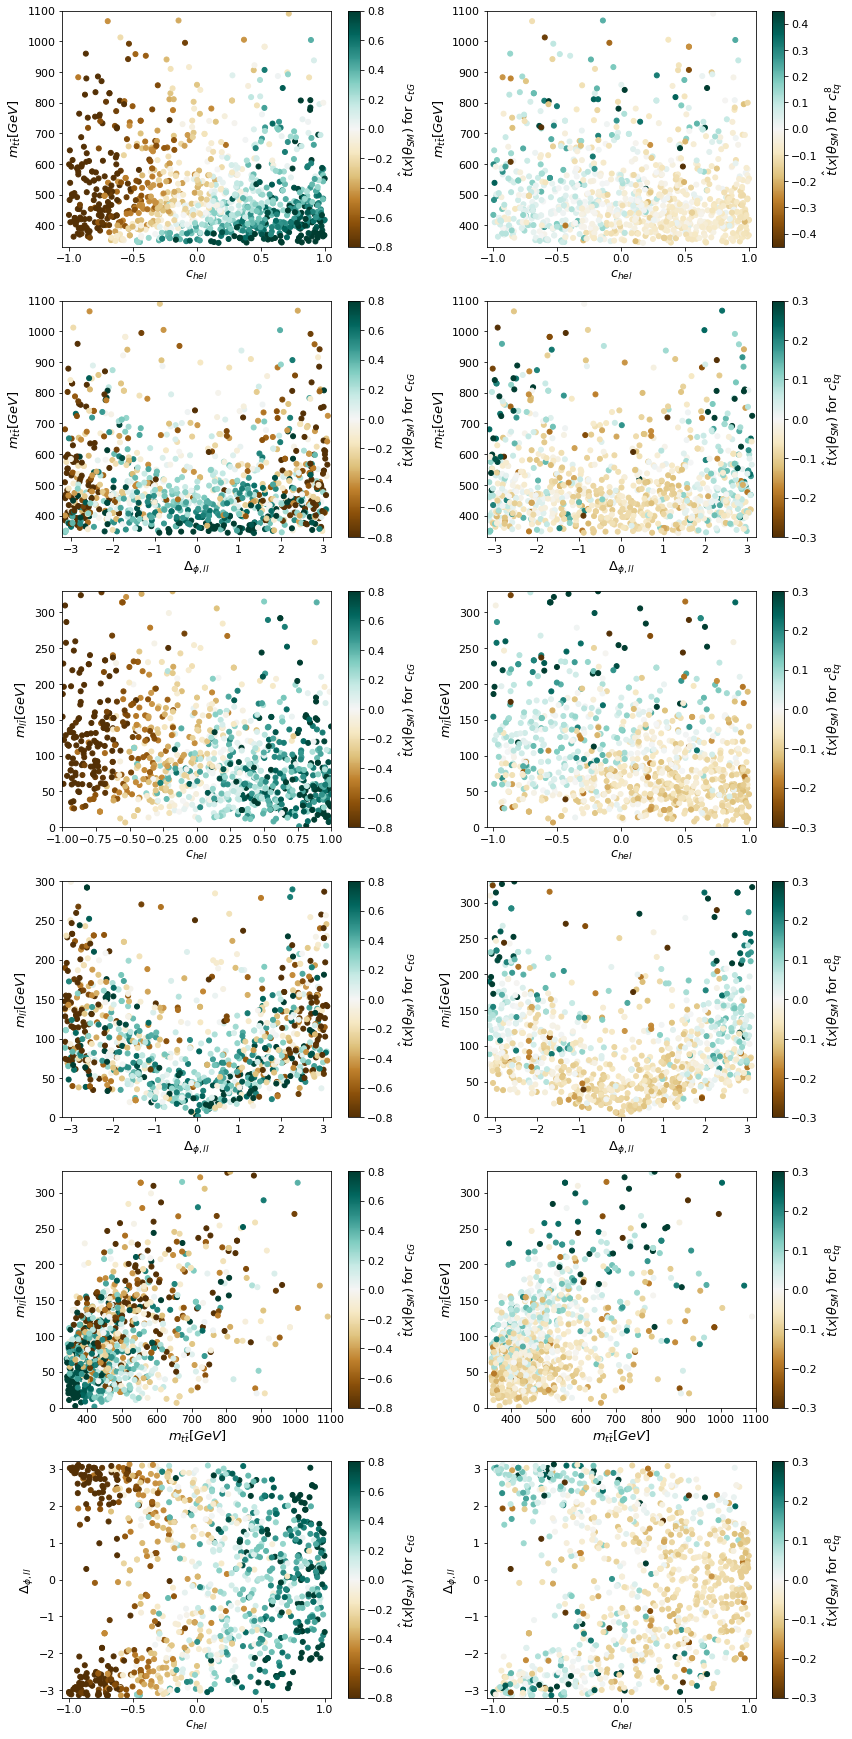

In [76]:
x = np.load("data/samples/x_test.npy")

fig = plt.figure(figsize=(12, 48))

plt.rcParams.update({'font.size': 11, 'axes.labelsize': 13}) #change 14 to whatever font size you want
#mtt vs chel
ax = plt.subplot(12, 2, 1)
sc = plt.scatter(
    x[:, 0],
    x[:, 1],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$c_{hel}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)

ax = plt.subplot(12, 2, 2)
sc = plt.scatter(
    x[:, 0],
    x[:, 1],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.45,
    vmax=+0.45,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$c_{hel}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(330, 1100)


#mtt vs delta_phi_ll
ax = plt.subplot(12, 2, 3)
sc = plt.scatter(
    x[:, 3],
    x[:, 1],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$\Delta_{\phi,ll}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-3.2, 3.2)
plt.ylim(330, 1100)

ax = plt.subplot(12, 2, 4)
sc = plt.scatter(
    x[:, 3],
    x[:, 1],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.3,
    vmax=+0.3,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$\Delta_{\phi,ll}$")
plt.ylabel(r"$m_{t\bart} [GeV]$")
plt.xlim(-3.2, 3.2)
plt.ylim(330, 1100)

#mll vs chel
ax = plt.subplot(12, 2, 5)
sc = plt.scatter(
    x[:, 0],
    x[:, 2],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$c_{hel}$")
plt.ylabel(r"$m_{l\barl} [GeV]$")
plt.xlim(-1., 1.)
plt.ylim(0, 330)

ax = plt.subplot(12, 2, 6)
sc = plt.scatter(
    x[:, 0],
    x[:, 2],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.3,
    vmax=+0.3,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$c_{hel}$")
plt.ylabel(r"$m_{l\barl} [GeV]$")
plt.xlim(-1.05, 1.05)
plt.ylim(0, 330)

#mll vs delta_phi
ax = plt.subplot(12, 2, 7)
sc = plt.scatter(
    x[:, 3],
    x[:, 2],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$\Delta_{\phi,ll}$")
plt.ylabel(r"$m_{l\barl} [GeV]$")
plt.xlim(-3.2, 3.2)
plt.ylim(0, 300)

ax = plt.subplot(12, 2, 8)
sc = plt.scatter(
    x[:, 3],
    x[:, 2],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.3,
    vmax=+0.3,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$\Delta_{\phi,ll}$")
plt.ylabel(r"$m_{l\barl} [GeV]$")
plt.xlim(-3.2, 3.2)
plt.ylim(0, 330)


#mll vs mtt
ax = plt.subplot(12, 2, 9)
sc = plt.scatter(
    x[:, 1],
    x[:, 2],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$m_{t\bart} [GeV]$")
plt.ylabel(r"$m_{l\barl} [GeV]$")
plt.xlim(330, 1100)
plt.ylim(0, 330)

ax = plt.subplot(12, 2, 10)
sc = plt.scatter(
    x[:, 1],
    x[:, 2],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.3,
    vmax=+0.3,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$m_{t\bart} [GeV]$")
plt.ylabel(r"$m_{l\barl} [GeV]$")
plt.xlim(330, 1100)
plt.ylim(0, 330)

#deltaphi vs chel
ax = plt.subplot(12, 2, 11)
sc = plt.scatter(
    x[:, 0],
    x[:, 3],
    c=t_hat[:, 0],
    s=25.0,
    cmap="BrBG",
    vmin=-0.8,
    vmax=+0.8,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c_{tG}$")
plt.xlabel(r"$c_{hel}$")
plt.ylabel(r"$\Delta_{\phi,ll}$")
plt.xlim(-1.05, 1.05)
plt.ylim(-3.2, 3.2)

ax = plt.subplot(12, 2, 12)
sc = plt.scatter(
    x[:, 0],
    x[:, 3],
    c=t_hat[:, 1],
    s=25.0,
    cmap="BrBG",
    vmin=-0.3,
    vmax=+0.3,
)

cbar = plt.colorbar(sc)

cbar.set_label(r"$\hat{t}(x | \theta_{SM})$ for $c^8_{tq}$")
plt.xlabel(r"$c_{hel}$")
plt.ylabel(r"$\Delta_{\phi,ll}$")
plt.xlim(-1.05, 1.05)
plt.ylim(-3.2, 3.2)


plt.tight_layout()
plt.show()

In [78]:
figFormats = ['png','pdf','svg']
for figF in figFormats:
    fig.savefig("figures/3b_score_score_scatterplots",format=figF)